# Understanding Current Exoplanet Populations Using a Little Monte Carlo

> Hello there! I created this code with two goals in mind: __to use a computational method in physics to better understand it, and to use real data to understand some of what we know today about the general question of habitability__. Since this is being created with a deadline for a class, and for people that are new to the field of exoplanets, and particular the question of habitability, I will be restricting the question we ask today to this - using the current database of exoplanets we have detected and confirmed within a small region of the Milky Way Galaxy, __how can we understand the potential for Earth-like habitable planets__? The probability? 


> To do so, we will use Earth as a comparison point throughout the notebook, and explore the population using mass and radius first, then stellar parameters. Looking at our Solar System, we know that the Earth is unique in its composition, temperature, size, and location. We will start with a dataset provided by using the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html), ensure that the dataset we actually use has both mass and radius for each planet entry, and then use a Monte Carlo sampling method to randomly select planets and their systems. We will then take those planets, and narrow them down to what the [Planetary Habitability Laboratory @ UPR Arecibo](https://phl.upr.edu/projects/habitable-exoplanets-catalog) considers apt mass and radius ranges, and reselect (randomly, again) some planets from within that range to see which, if any, fall within a Goldilocks zone from their host star/s - the area that surrounds that "just right" spot that Earth lives in. Maybe then we might find some optimism or skepticism about the question of whether we have the most unique planet out there!


In [1]:
# Here is the code for turning our csv data file into a dictionary to use for analyzing the data
# You may need to use "pip install" in a terminal window, and install pandas, numpy, matplotlib, and other such libraries
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from moviepy.editor import ImageSequenceClip
import natsort as nt
from IPython.display import Video
import re
import os

# Initializing the style I want to use, you can look up 'plt.style.use' to find out what you'd like to use!
plt.style.use('Solarize_Light2')

# A function just to make our lives easier with spacing issues when it comes to naming things, it just replaces spaces with underscores
def rename(name):
    name = name.replace(' ', '_')
    return name

# Creating a dataframe
exo_data = pd.read_csv(r'/Users/shirin/Desktop/comp_meth/final_project/exo_data.csv', encoding='unicode_escape', comment='#')
print(len(exo_data))
exo_data.head(20) # showing the top 20 lines of the dataframe

5557


,pl_name,hostname,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_metratio,st_lum,rastr,ra,decstr,dec
0,11 Com b,11 Com,323.21000,1.178,12.200,4914.89849,0.238,NaN,NaN,G8 III,4874.0,13.76,[Fe/H],1.978,12h20m42.91s,185.178779,+17d47m35.71s,17.793252
1,11 UMi b,11 UMi,516.21997,1.530,12.300,4684.81420,0.080,NaN,NaN,K4 III,4213.0,29.79,[Fe/H],2.430,15h17m05.90s,229.274595,+71d49m26.19s,71.823943
2,14 And b,14 And,186.76000,0.775,13.100,1131.15130,0.000,NaN,NaN,K0 III,4888.0,11.55,[Fe/H],1.840,23h31m17.80s,352.824150,+39d14m09.01s,39.235837
3,14 Her b,14 Her,1765.03890,2.774,12.600,2559.47216,0.373,NaN,NaN,K0 V,5338.0,0.93,[Fe/H],-0.153,16h10m24.50s,242.602101,+43d48m58.90s,43.816362
4,16 Cyg B b,16 Cyg B,798.50000,1.660,13.500,565.73740,0.680,NaN,NaN,G3 V,5750.0,1.13,[Fe/H],0.097,19h41m51.75s,295.465642,+50d31m00.57s,50.516824
5,17 Sco b,17 Sco,578.38000,1.450,12.900,1373.01872,0.060,NaN,NaN,K3 III,4157.0,25.92,[Fe/H],2.254,16h13m50.90s,243.462087,-11d50m16.05s,-11.837791
6,18 Del b,18 Del,982.85000,2.476,12.500,2926.24614,0.024,NaN,NaN,G6 III,4980.0,8.80,[Fe/H],1.634,20h58m25.88s,314.607838,+10d50m20.90s,10.839138
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524,NaN,330.000,18.647,3000.00000,NaN,NaN,1700.0,K7 V,4060.0,1.31,NaN,-0.370,16h09m30.30s,242.376234,-21d04m59.31s,-21.083140
8,24 Boo b,24 Boo,30.33000,0.194,13.900,280.64248,0.032,NaN,NaN,G3 IV,4816.0,12.19,[Fe/H],1.877,14h28m37.33s,217.155524,+49d50m40.74s,49.844649
9,24 Sex b,24 Sex,452.80000,1.333,13.400,632.46000,0.090,NaN,NaN,K0 IV,5098.0,4.90,[Fe/H],1.164,10h23m28.44s,155.868487,-00d54m08.64s,-0.902400


> The dataframe above displays the header, or top 5 rows of data that we put into the code (unless we specify, like we did, that we want to see 20 lines). Currently, the dataframe includes 5557 planetary systems, noting the planet name, host star name, the planet's orbital period, the planet's semi-major axis (furthest distance from the host star/s), radius in Earth radii, mass in Earth masses, orbital eccentricity, insolation flux, equilibrium temperature, the star's spectral type, effective temperature, radius in solar radii, metallicity ratio, luminosity, and the system's right ascension and declination in both sexagesimal and decimal systems, all as keys. As you can see, there are lots of NaN values in the data, but we'll deal with that in a little bit. For the ease of understanding what we're looking at, let's clean up the names of the data!

In [2]:
# Renaming the columns... It's a long line of code.
exo_data = exo_data.rename(columns={'pl_name': 'Planet Name', 'hostname': 'Star Name', 'pl_orbper': 'Orbital Period [days]', 'pl_orbsmax': 'Semimajor Axis [au]', 'pl_rade': 'Planet Radius [Earth radii]', 'pl_bmasse': 'Planet Mass [Earth masses]', 'pl_orbeccen': 'Eccentricity', 'pl_insol': 'Insolation Flux [Earth flux]', 'pl_eqt': 'Equilibrium Temperature [K]', 'st_spectype': 'Spectral Type', 'st_teff': 'Stellar Effective Temperature [K]', 'st_rad': 'Stellar Radius [solar radii]', 'st_metratio': 'Stellar Metallicity Ratio', 'st_lum': 'Stellar Luminosity [log10(solar)]', 'rastr': 'RA [sexagesimal]', 'ra': 'RA [decimal]', 'decstr': 'Dec [sexagesimal]', 'dec': 'Dec [decimal]'})

> The way we renamed this might seem a bit painful (as some of the keys are now quite wordy), but at least personally it feels worth it when the plots show the data, and the axes show us exactly what the data is, including the units! A few of the keys we should keep in mind are mass, radius, semimajor axis (in astronomical units (au) the distance from the center of an ellipse to the farther point out on it, and we can consider it some measure of a distance from the star although we must keep in mind that not all orbits in the Universe are circular), stellar luminosity (the total amount of energy radiated by the star relative to the Sun), insolation flux (the amount of stellar radiation received by a planet), and stellar effective temperature (the energy/heat the star radiates, in Kelvin). As we go forward, keep in mind that the __Earth is 1 Earth mass, 1 Earth radius, and 1 AU away from the Sun, with 1 Earth flux for its insolation flux__. __The Sun's temperature is 5780 K, and its luminosity is 1 solar luminosity__.

> As you've seen from the dataframe above, we have multiple parameters of data to work with when it comes to exoplanets. When you play around with it, you can manipulate/use whatever data you want to plot. For now, let's begin to explore our chosen question in exoplanet science with the dataframe we have, the question of habitability. For that, we should try and use the masses and radii of the planets we want to work with! You'll note that both those parameters are listed in Earth terms as mentioned above. I personally feel that using the Earth as a relative object is easiest because I've had to think about it for longer than any other planet.

> Let's take a look at the masses and radii of the planets, first on a larger scale (notice the plot going from 0 to 1000 times the radius of Earth, and 0 to 40 times the mass of Earth), then with a closer eye (out to 10 Earth radii and 2 Earth masses). 

AttributeError: PathCollection.set() got an unexpected keyword argument 'markersize'

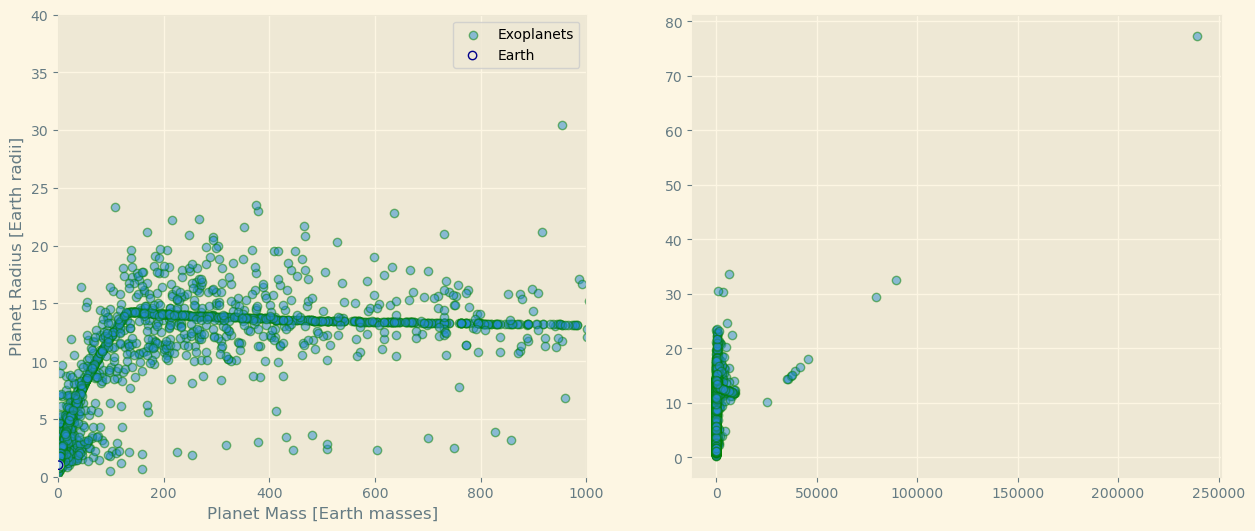

In [3]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)
ax1.scatter(exo_data['Planet Mass [Earth masses]'], exo_data['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green', label='Exoplanets')
ax1.scatter(1,1,marker='o', color='darkblue', label='Earth', facecolor='none', zorder=1000)
ax1.scatter(1,1,marker='o', color='white', alpha=0.5, zorder=999)
ax1.set_xlabel('Planet Mass [Earth masses]')
ax1.set_ylabel('Planet Radius [Earth radii]')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,40)
plt.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(exo_data['Planet Mass [Earth masses]'], exo_data['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green', label='Exoplanets')
ax2.scatter(1,1,marker='o', color='darkblue', label='Earth', facecolor='none', markersize=10, zorder=1000)
ax2.scatter(1,1,marker='o', color='white', alpha=0.5, markersize=10, zorder=999)
ax2.set_xlabel('Planet Mass [Earth masses]')
ax2.set_ylabel('Planet Radius [Earth radii]')
ax2.set_xlim(0,10)
ax2.set_ylim(0,2)

plt.legend()

> Notice how the density of points on the first plot around 5 Earth radii and 50 Earth mass region makes it quite difficult to tell how dense it really is, and you can even see something really interesting in the second plot. It shows this linear track of points, individual planets, from half an Earth radius up and out to 5 Earth masses. Now, another thing I want to draw your eye to is the marker for Earth. To make it easy, we'll keep it the same throughout the notebook, and use it as a way to _ground_ ourselves... Earth seems to fit the most densely populated region of the first plot, and even in the second one, falls quite well along that peculiar linear track. We should keep that in mind, and treat Earth like a little "Where's Waldo" situation going forward.

> To continue using the data, I want to clean it up. We had a lot of NaNs showing in the header of the dataframe, and I think it'll make it much easier to use multiple parameters at once, so we're not worrying about planets missing parameters such as mass being plotted. We want our idea of the population to be represented clearly by all the parameters, and not be concerned that we might have some planets with mass but without radius weighing down our plots with inaccurate 0 Earth radii values.

In [ ]:
#Check for NaNs in the columns
#nan_checker = exo_data[exo_data['Planet Mass [Earth Masses]'].isnull()]
#print("Rows with NaN values:")
#print(nan_checker)

In [ ]:
exo_data = exo_data.dropna(subset=['Planet Mass [Earth masses]','Planet Radius [Earth radii]'])
print(len(exo_data))
#nan_checker = exo_data['Planet Mass [Earth Masses]'].isnull()
#print("Rows with NaN values:")
#print(nan_checker)

> Now that we've cleaned the data up, we can see it only contains 731 planets. That's about 13% of our original database, and shows (unfortunately) how sparse "complete" sets of data are for exoplanets. Still, since we're insisting on having _all_ the parameters available to us, it's best to indiscriminately remove planets containing NaNs. If you're okay with having planets that may be missing on a few values in their data, you can go ahead and comment outthe above box!

In [ ]:
ax = exo_data.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', alpha=0.3, xlim=(0,4000), ylim=(0,40), kind='scatter', logx=True, logy=True, s=50, edgecolor='green', label='Exoplanets')
ax.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10, zorder=999)
ax.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', zorder=1000, label='Earth')
ax.legend()

In [ ]:
ax = exo_data.plot.scatter(x='Insolation Flux [Earth flux]', y='Stellar Effective Temperature [K]', alpha=0.5, s=50, xlim=(0,20), ylim=(-1,8000), edgecolor='green', label='Exoplanets')
ax.plot(1, 5780, marker='o', color='white', alpha=0.5, markersize=10)
ax.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth')

ax.legend()
plt.show()

> We now want to use a MC method to sample from the population database, and we want to make it generalizable so that I can call on an argument and just use it. I should create a function that takes all arguments that are headers in the file, and then runs the MC method on them.

In [ ]:
N_1 = 350 # number of planets we want to sample
def mc_sampling(exo_data, x, y, xaxis, yaxis): # these are variables we can change and generalize at the bottom of the block
    exo_list = len(exo_data)
    choose_exos = []
     
    directory = str(N_1)+'_planets/'
    directory = rename(directory)
    os.makedirs(directory, exist_ok=True)
    parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
    image_folder=os.path.join(parent_dir, directory)

    for i in range(N_1):
        random_select = np.random.randint(0, exo_list-1) # randomly selecting a number from a bucket, where each number is assigned to a planet
        choose_exos.append(exo_data.iloc[random_select]) # appending the list we created

        #Plotting each point 
        plt.figure(figsize=(6,6))
        plt.title('Monte Carlo Sampling')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        plt.xlim(0, xaxis)
        plt.ylim(0, yaxis)
        plt.scatter(choose_exos[-1][x], choose_exos[-1][y], color='red', marker='o') # using a red marker to mark each new point put down
        
        for j in range(i+1):
            plt.scatter(choose_exos[j][x], choose_exos[j][y], marker='o', alpha=0.5) # plotting each point in randomly selected
            
        plt.savefig(directory+str(i)+'.png')
        plt.close()

    plt.show(block=False)    
    return pd.DataFrame(choose_exos)

random_exos = mc_sampling(exo_data, x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', xaxis=2000, yaxis=30)
mceed_exos = pd.DataFrame(random_exos)
#print(random_exos)

> Let's make a video!

In [ ]:
directory = str(N_1)+'_planets/'
directory = rename(directory)
os.makedirs(directory, exist_ok=True)
parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
image_folder=os.path.join(parent_dir, directory)

# Collect image files from the folder
image_files = sorted([os.path.join(image_folder, img)
                    for img in os.listdir(image_folder)
                    if img.endswith(".png")], key=lambda x: int(''.join(filter(str.isdigit, x))))

#Let's save our video!
fps = 2
clip = ImageSequenceClip(image_files, fps=fps)
output_video = str(N_1)+'_planets_output.mp4'
clip.write_videofile(output_video, codec='libx264', fps=fps)
Video(output_video)


> The above random selection and movie-making code are to show how planets are selected at random. Since we know we have a total of 731 planets, and we sampled 200 of them, we are looking at 200/731 planets, or about 27% of the planets!

In [ ]:
mceed_exos.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', alpha=0.5, s=50, edgecolor='green')

> Now, to take a look at our distribution, we should add our boundaries. A helpful way to figure out what boundaries will be helpful in figuring out which planets can be hypothetically considered habitable candidates, we can narrow down the masses and radii. I'll be using ranges considered by the Planetary Habitability Laboratory. As mentioned at the beginning, I personally think that a planet's mass and radius are easier to think about as we're thinking about the potential habitability of the planet itself, so we'll start with those bounds and then have further discussions about the host star/condition of the system. We're going to zoom in much deeper on the plot, where you may have noticed there's a high density of planets. Since we're going to just start with these two parameters, I think we can consider ourselves absurdly hopefully optimists and we'll take a look at data from the PHL @ UPR Arecibo's optimistic range combined with their conservative range. Our values will go from 0.5<Radius<2.5 and 0.1<Mass<10.

In [ ]:
bounding_mask = (mceed_exos['Planet Mass [Earth masses]'] >= 0.1) & (mceed_exos['Planet Mass [Earth masses]'] <= 10) & (mceed_exos['Planet Radius [Earth radii]'] >= 0.5) & (mceed_exos['Planet Radius [Earth radii]'] <= 2.5)
mceed_exos = mceed_exos[bounding_mask]

In [ ]:
ax = exo_data.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', alpha=0.2, s=50, edgecolor='green', label='All Exoplanets')
ax.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
mceed_exos.plot(x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', kind='scatter', logx=True, logy=True, s=60, ax=ax, color='blue', marker='*', alpha=1, label='Randomly Selected Exoplanets within Range')

plt.legend()
print(len(random_exos))

In [ ]:
ax = mceed_exos.plot(x='Semimajor Axis [au]', y='Stellar Effective Temperature [K]', kind='scatter', alpha=0.5, edgecolor='green', label='Randomly Selected Exoplanets within Range')
ax.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.scatter(mceed_exos['Insolation Flux [Earth flux]'], mceed_exos['Stellar Effective Temperature [K]'], alpha=0.5, edgecolor='green')
ax1.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax1.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax1.set_xlabel('Insolation Flux')
ax1.set_ylabel('Stellar Effective Temperature')

ax2 = fig.add_subplot(132)
ax2.scatter(mceed_exos['Semimajor Axis [au]'], mceed_exos['Stellar Luminosity [log10(solar)]'], alpha=0.5, edgecolor='green')
ax2.plot(1, 0, marker='o', color='white', alpha=0.2, markersize=10)
ax2.plot(1, 0, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax2.set_xlabel('Semimajor Axis')
ax2.set_ylabel('Stellar Luminosity')

ax3 = fig.add_subplot(133)
ax3.scatter(mceed_exos['Planet Mass [Earth masses]'], mceed_exos['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green')
ax3.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax3.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax3.set_xlabel('Planet Mass')
ax3.set_ylabel('Planet Radius')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
N_2 = 35
def mc_sampling(data, x, y, xaxis, yaxis):
    exo_list = len(data)
    choose_exos = []
     
    directory = 'twice_'+str(N_2)+'_planets/'
    directory = rename(directory)
    os.makedirs(directory, exist_ok=True)
    parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
    image_folder=os.path.join(parent_dir, directory)

    for i in range(N_2):
        random_select = np.random.randint(0, exo_list-1)
        choose_exos.append(mceed_exos.iloc[random_select])

        #Plotting each point 
        plt.figure(figsize=(6,6))
        plt.title('Monte Carlo Sampling')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        plt.xlim(0, xaxis)
        plt.ylim(0, yaxis)
        plt.scatter(choose_exos[-1][x], choose_exos[-1][y], color='red', marker='o')
        
        for j in range(i+1):
            plt.scatter(choose_exos[j][x], choose_exos[j][y], marker='o', alpha=0.5)
            
        plt.savefig(directory+str(i)+'.png')
        plt.close()

    plt.show(block=False)    
    return pd.DataFrame(choose_exos)

mceed_exos2 = mc_sampling(mceed_exos, x='Planet Mass [Earth masses]', y='Planet Radius [Earth radii]', xaxis=10, yaxis=3)
mceed_exos2.head(20)

In [ ]:
directory = 'twice_'+str(N_2)+'_planets/'
directory = rename(directory)
os.makedirs(directory, exist_ok=True)
parent_dir = "/Users/shirin/Desktop/comp_meth/final_project/"
image_folder=os.path.join(parent_dir, directory)
# Collect image files from the folder
image_files = sorted([os.path.join(image_folder, img)
                    for img in os.listdir(image_folder)
                    if img.endswith(".png")], key=lambda x: int(''.join(filter(str.isdigit, x))))

#Let's save our video!
fps = 1
clip = ImageSequenceClip(image_files, fps=fps)
output_video = 'twice_'+str(N_2)+'_planets_output.mp4'
clip.write_videofile(output_video, codec='libx264', fps=fps)
Video(output_video)

In [ ]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(131)
ax1.scatter(mceed_exos2['Insolation Flux [Earth flux]'], mceed_exos2['Stellar Effective Temperature [K]'], alpha=0.5, edgecolor='green')
ax1.plot(1, 5780, marker='o', color='white', alpha=0.2, markersize=10)
ax1.plot(1, 5780, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax1.set_xlabel('Insolation Flux')
ax1.set_ylabel('Stellar Effective Temperature')

ax2 = fig.add_subplot(132)
ax2.scatter(mceed_exos2['Semimajor Axis [au]'], mceed_exos2['Stellar Luminosity [log10(solar)]'], alpha=0.5, edgecolor='green')
ax2.plot(1, 0, marker='o', color='white', alpha=0.2, markersize=10)
ax2.plot(1, 0, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax2.set_xlabel('Semimajor Axis')
ax2.set_ylabel('Stellar Luminosity')

ax3 = fig.add_subplot(133)
ax3.scatter(mceed_exos2['Planet Mass [Earth masses]'], mceed_exos2['Planet Radius [Earth radii]'], alpha=0.5, edgecolor='green')
ax3.plot(1, 1, marker='o', color='white', alpha=0.2, markersize=10)
ax3.plot(1, 1, marker='o', color='darkblue', markersize=10, markerfacecolor='none', label='Earth', zorder=1000)
ax3.set_xlabel('Planet Mass')
ax3.set_ylabel('Planet Radius')

plt.subplots_adjust(wspace=0.5)
plt.show()

As we can see above, marking down where Earth is can be quite helpful. In terms of just mass and radius, since we selected what we wanted to see using a mask, we cn comfortably say that we've selected 